# Tutorial 30: Protein Deep Learning 

n this tutorial we will  compare featurization of protein sequences such as one hot encoders and aminoacids composition. We will use some tools of DeepChem and additional packages to create a model to predict melting temperature of proteins ( a good measurement of protein stability )    
   
the Melting temperature (MT) of a protein is a measurement of protein stability. This measure could vary from a big variety of experimental conditions, however, curated databases cand be found in literature https://aip.scitation.org/doi/10.1063/1.4947493. In this paper we can find a lot of thermodynamicall information of proteins and therefore a a big resource for the study of protein stability. Other information related with protein stability could be the change in Gibbs Free Energy $ \Delta \Delta G°$ due to a mutatation. 

The study of protein stability is important in areas such as protein engineering and biocatalysis 

# Setup
To run DeepChem within Colab, you'll need to run the following installation commands. This will take about 5 minutes to run to completion and install your environment. You can of course run this tutorial locally if you prefer. In that case, don't run these cells since they will download and install Anaconda on your local machine.

In [1]:
#!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
#import conda_installer
#conda_installer.install()
#!/root/miniconda/bin/conda info -e

In [2]:
#!pip install --pre deepchem
#!pip install propy3 

# Data extraction

In [3]:
import deepchem as dc 
import os 
from deepchem.utils import download_url
data_dir = dc.utils.get_data_dir()
dataset_file = os.path.join(data_dir, "pucci-proteins-appendixtable1.csv")
if not os.path.exists(dataset_file):
    print('File does not exist. Downloading file...')
    download_url("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/pucci-proteins-appendixtable1.csv")
    print('File downloaded...')


In [4]:
import pandas as pd 
data = pd.read_csv("pucci-proteins-appendixtable1.csv")
data

,Unnamed: 0,N,PDBid,Chain,RESN,RESwt,RESmut,ΔTmexp,Tmexp [wt],ΔΔHmexp,...,ΔΔGexp(T),T,Nres,R (Å),Protein,Organism,Ref.,pH,Exp.Tech.,
0,NaN,1,1aky,A,8,VAL,ILE,-1.5,47.6,70,...,5.0,25,220,1.63,ADK,Yeast,[1],[7.5],FL,NaN
1,NaN,2,1aky,A,48,GLN,GLU,-1.3,47.6,60,...,4.0,25,220,1.63,ADK,Yeast,[1],[7.7],FL,NaN
2,NaN,3,1aky,A,77,THR,HIS,-1.1,47.6,130,...,9.0,25,220,1.63,ADK,Yeast,[1],[7.5],FL,NaN
3,NaN,4,1aky,A,110,THR,HIS,-4.8,47.6,165,...,11.0,25,220,1.63,ADK,Yeast,[1],[7.6],FL,NaN
4,NaN,5,1aky,A,169,ASN,ASP,-0.6,47.6,140,...,9.0,25,220,1.63,ADK,Yeast,[1],[7.5],FL,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,NaN,1622,5pti_m52l,A,15,LYS,SER,-1.3,91.7,-5,...,1.2,25,58,1.00,PTI M52L,Bovine,[232],[3.0],DSC,NaN
1622,NaN,1623,5pti_m52l,A,15,LYS,THR,-1.1,91.7,-9,...,-3.6,25,58,1.00,PTI M52L,Bovine,[232],[3.0],DSC,NaN
1623,NaN,1624,5pti_m52l,A,15,LYS,VAL,-6.3,91.7,4,...,4.7,25,58,1.00,PTI M52L,Bovine,[232],[3.0],DSC,NaN
1624,NaN,1625,5pti_m52l,A,15,LYS,TRP,-7.5,91.7,17,...,8.5,25,58,1.00,PTI M52L,Bovine,[232],[2.5],DSC,NaN


In [5]:
WT_Tm = data[['PDBid','Tmexp [wt]']]
WT_Tm.set_index('PDBid',inplace=True)
#WT_Tm.drop_duplicates(inplace=True)

In [6]:
dict_WT_TM = {}
for k,v in WT_Tm.itertuples():
    if(k not in dict_WT_TM):
        dict_WT_TM[k]=float(v)

In [7]:
#Extract data that only has mutations in Chain A 
pdbs = data[data['PDBid'].str.len()<5]
pdbs = pdbs[pdbs['Chain'] == "A"]

In [8]:
pdbs[['RESN','RESwt','RESmut']]

,RESN,RESwt,RESmut
0,8,VAL,ILE
1,48,GLN,GLU
2,77,THR,HIS
3,110,THR,HIS
4,169,ASN,ASP
...,...,...,...
1604,36,GLY,ALA
1605,36,GLY,SER
1606,37,GLY,ALA
1607,39,ARG,ALA


This cell extracts the total number of mutations and changes in MT. In addition, we use a dicctionary to convert the residue mutation in a one letter code.

In [9]:
alls=[]
for resnum,wt in pdbs[['RESN','RESwt','RESmut','PDBid','ΔTmexp']].iteritems():
    alls.append(wt.values)
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
resnum=alls[0]
wt=[d[x.strip()] for x in alls[1]]
mut=[d[x.strip()] for x in alls[2]]
codes=alls[3]
tms=alls[4]

In [10]:
print("pdbid {}, WTAA {}, Resnum {}, MUTAA {},DeltaTm {}".format(codes[0],wt[0],resnum[0],mut[0],tms[0]))


pdbid 1aky, WTAA V, Resnum 8, MUTAA I,DeltaTm -1.5


# PDB donwload 

Here we download all the pdbs by PDBID using the pdbfixer tool

In [11]:
from pdbfixer import PDBFixer
from simtk.openmm.app import PDBFile

In [12]:
!mkdir PDBs

mkdir: cannot create directory ‘PDBs’: File exists


In [13]:
import os 
downloaded = os.listdir("PDBs")
PDBs_ids= set(pdbs['PDBid'])
import time
t0 = time.time()
pdb_list = []
for pdbid in PDBs_ids:
    name=pdbid+".pdb"
    if(name in downloaded):
        print("{} already downloaded".format(name), end=" ")
        continue
    print("downloading {}".format(pdbid),end =" ")
    try:
        fixer = PDBFixer(pdbid=pdbid)
        fixer.findMissingResidues()
        fixer.findNonstandardResidues()
        fixer.replaceNonstandardResidues()
        fixer.removeHeterogens(True)
        fixer.findMissingAtoms()
        fixer.addMissingAtoms()
        PDBFile.writeFile(fixer.topology, fixer.positions, open('./PDBs/%s.pdb' % (pdbid), 'w'),keepIds=True)
    except:
        print("Problem with {}".format(pdbid))
print("TotalTime {}".format(time.time()-t0))

1fhl.pdb already downloaded 2ov0.pdb already downloaded 1wq5.pdb already downloaded 1brf.pdb already downloaded 1azp.pdb already downloaded 3sil.pdb already downloaded 1gv5.pdb already downloaded 1fna.pdb already downloaded 1h7m.pdb already downloaded 1t69.pdb already downloaded 1csp.pdb already downloaded 1sup.pdb already downloaded 1onc.pdb already downloaded 451c.pdb already downloaded 2hbb.pdb already downloaded 1kf2.pdb already downloaded 1ju3.pdb already downloaded 1lni.pdb already downloaded 1f6r.pdb already downloaded 2a01.pdb already downloaded 1esf.pdb already downloaded 1olr.pdb already downloaded 1ayf.pdb already downloaded 1poh.pdb already downloaded 1h8v.pdb already downloaded 1yea.pdb already downloaded 1aqh.pdb already downloaded 4blm.pdb already downloaded 1shf.pdb already downloaded 5dfr.pdb already downloaded 4u2b.pdb already downloaded 1avr.pdb already downloaded 1l63.pdb already downloaded 3uue.pdb already downloaded 1tca.pdb already downloaded 2cpp.pdb already dow

The following function help us to mutate a sequence denoted as  A###B where A is the wildtype aminoacid, ### the position and, B the new aminoacid 

In [14]:
import re
def MutateSeq(seq,Mutant):
    '''
    mutate a sequence based on a string (Mutant) that has the notation : 
    A###B where A is the wildtype aminoacid ### the position and B the mutation
    '''
    aalist = re.findall('([A-Z])([0-9]+)([A-Z])', Mutant)
    
    #(len(aalist)==1):
    newseq=seq
    listseq=list(newseq)
    for aas in aalist:
        wildAA = aas[0]
        pos = int(aas[1]) -1
        if(pos >= len(listseq)):
            print("Mutation not in the range of the protein")
            return None
        MutAA = aas[-1]
        
        if(listseq[pos]==wildAA):
            
            listseq[pos]=MutAA
            
        else:
            print("WildType AA does not match")
            return None
    return("".join(listseq))

The following function help us to identify a sequence of aminoacids base on PDB structures

In [15]:
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Polypeptide import PPBuilder
ppb=PPBuilder()
def GetSeqFromPDB(pdbid):
    structure = PDBParser().get_structure(pdbid.split(".")[0], 'PDBs/{}'.format(pdbid))
    seqs=[]
    return ppb.build_peptides(structure)
    

Some examples of the described functions 

In [16]:
test=codes[0]
print(test)
seq = GetSeqFromPDB("{}.pdb".format(test))[0].get_sequence()
print("Original Sequence")
print(seq)
informSeq=GetSeqFromPDB(test+".pdb")[0].__repr__()
print("Seq information",informSeq)
start = re.findall('[0-9]+',informSeq)[0]
print("Reported Mutation {}{}{}".format(wt[0],resnum[0],mut[0]))
numf =resnum[0] - int(start) + 1 
mutfinal = "{}{}{}".format(wt[0],numf,mut[0])
print("Real Mutation = ",mutfinal)
mutseq = MutateSeq(seq,mutfinal)
print(mutseq)

1aky
Original Sequence
SSESIRMVLIGPPGAGKGTQAPNLQERFHAAHLATGDMLRSQIAKGTQLGLEAKKIMDQGGLVSDDIMVNMIKDELTNNPACKNGFILDGFPRTIPQAEKLDQMLKEQGTPLEKAIELKVDDELLVARITGRLIHPASGRSYHKIFNPPKEDMKDDVTGEALVQRSDDNADALKKRLAAYHAQTEPIVDFYKKTGIWAGVDASQPPATVWADILNKLGKN
Seq information <Polypeptide start=1 end=220>
Reported Mutation V8I
Real Mutation =  V8I
SSESIRMILIGPPGAGKGTQAPNLQERFHAAHLATGDMLRSQIAKGTQLGLEAKKIMDQGGLVSDDIMVNMIKDELTNNPACKNGFILDGFPRTIPQAEKLDQMLKEQGTPLEKAIELKVDDELLVARITGRLIHPASGRSYHKIFNPPKEDMKDDVTGEALVQRSDDNADALKKRLAAYHAQTEPIVDFYKKTGIWAGVDASQPPATVWADILNKLGKN


/home/david/anaconda3/envs/deepchem-night/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2465
  warnings.warn(
/home/david/anaconda3/envs/deepchem-night/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2465
  warnings.warn(


In [17]:
test=codes[10]
print(test)
seq = GetSeqFromPDB("{}.pdb".format(test))[0].get_sequence()
print("Original Sequence")
print(seq)
informSeq=GetSeqFromPDB(test+".pdb")[0].__repr__()
print("Seq information",informSeq)
start = re.findall('[0-9]+',informSeq)[0]
print("Reported Mutation {}{}{}".format(wt[10],resnum[10],mut[10]))
numf =resnum[10] - int(start) + 1 
mutfinal = "{}{}{}".format(wt[10],numf,mut[10])
print("Real Mutation = ",mutfinal)
mutseq = MutateSeq(seq,mutfinal)
print(mutseq)

1ank
Original Sequence
MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG


/home/david/anaconda3/envs/deepchem-night/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4073.
  warnings.warn(
/home/david/anaconda3/envs/deepchem-night/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4335.
  warnings.warn(
/home/david/anaconda3/envs/deepchem-night/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4608
  warnings.warn(


Seq information <Polypeptide start=1 end=214>
Reported Mutation R88G
Real Mutation =  R88G
MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPGTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG


/home/david/anaconda3/envs/deepchem-night/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4073.
  warnings.warn(
/home/david/anaconda3/envs/deepchem-night/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4335.
  warnings.warn(
/home/david/anaconda3/envs/deepchem-night/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 4608
  warnings.warn(


In this for loop we extract the sequences of all proteins in the dataset. In addition we created the mutated sequences and append the change in MT. In some cases, gaps in pdbs will cause that mutateSeq function fails. therefore this entries will be avoided.

In [18]:
import warnings; warnings.simplefilter('ignore')
information = {}
count = 1
failures=[]
for code,tm,numr,wt_val,mut_val in zip(codes,tms,resnum,wt,mut):
    #print(count,code)
    #if(code=="1ycc"):
    count += 1
    print(count,end = " ")
    if(count%25==1):
        print()
    seq = GetSeqFromPDB("{}.pdb".format(code))[0].get_sequence()
    mutfinal="WT"
    if("{}-{}".format(code,mutfinal) not in information):
        information["{}-{}".format(code,mutfinal)]=[str(seq),dict_WT_TM[code]]
    #print("Original Sequence")
    #print(seq)
    informSeq=GetSeqFromPDB(code+".pdb")[0].__repr__()
    #print("Seq information",informSeq)
    start = re.findall('[-0-9]+',informSeq)[0]
    #print(start)
    #print("Reported Mutation {}{}{}".format(wt_val,numr,mut_val))
    if(int(start)<0):
        numf =numr - int(start) # if start is negative 0 is not used as resnumber
    else:
        numf =numr - int(start) + 1 
    mutfinal = "{}{}{}".format(wt_val,numf,mut_val)
    #print("Real Mutation = ",mutfinal)
    mutseq = MutateSeq(seq,mutfinal)
    if(mutseq==None):
        #print(type(seq))
        #print(code)
        failures.append((code,mutfinal))
        continue
    #print(mutseq)
    information["{}-{}".format(code,mutfinal)]=[mutseq,dict_WT_TM[code]-float(tm)]


2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 
52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 
77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 
102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 
127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 
152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 
177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 
202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 
227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 
252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 

In [19]:
information

{'1aky-WT': ['SSESIRMVLIGPPGAGKGTQAPNLQERFHAAHLATGDMLRSQIAKGTQLGLEAKKIMDQGGLVSDDIMVNMIKDELTNNPACKNGFILDGFPRTIPQAEKLDQMLKEQGTPLEKAIELKVDDELLVARITGRLIHPASGRSYHKIFNPPKEDMKDDVTGEALVQRSDDNADALKKRLAAYHAQTEPIVDFYKKTGIWAGVDASQPPATVWADILNKLGKN',
  47.6],
 '1aky-V8I': ['SSESIRMILIGPPGAGKGTQAPNLQERFHAAHLATGDMLRSQIAKGTQLGLEAKKIMDQGGLVSDDIMVNMIKDELTNNPACKNGFILDGFPRTIPQAEKLDQMLKEQGTPLEKAIELKVDDELLVARITGRLIHPASGRSYHKIFNPPKEDMKDDVTGEALVQRSDDNADALKKRLAAYHAQTEPIVDFYKKTGIWAGVDASQPPATVWADILNKLGKN',
  49.1],
 '1aky-Q48E': ['SSESIRMVLIGPPGAGKGTQAPNLQERFHAAHLATGDMLRSQIAKGTELGLEAKKIMDQGGLVSDDIMVNMIKDELTNNPACKNGFILDGFPRTIPQAEKLDQMLKEQGTPLEKAIELKVDDELLVARITGRLIHPASGRSYHKIFNPPKEDMKDDVTGEALVQRSDDNADALKKRLAAYHAQTEPIVDFYKKTGIWAGVDASQPPATVWADILNKLGKN',
  48.9],
 '1aky-T77H': ['SSESIRMVLIGPPGAGKGTQAPNLQERFHAAHLATGDMLRSQIAKGTQLGLEAKKIMDQGGLVSDDIMVNMIKDELHNNPACKNGFILDGFPRTIPQAEKLDQMLKEQGTPLEKAIELKVDDELLVARITGRLIHPASGRSYHKIFNPPKEDMKDDVTGEALVQRSDDNADALKKRLAAYHAQTEPIVDFYKKTGIWAGVDASQPPATVWADILNKLGKN',
  48.7],
 '1aky-T110

# Deep Learning and Machine Learning Models using proteins sequences 

In [20]:
import deepchem as dc

In [21]:
seq_list=[]
deltaTm=[]
for i in information.values():
    seq_list.append(i[0])
    deltaTm.append(i[1])

In [23]:
max_seq= 0 
for i in seq_list:
    if(len(i)>max_seq):
        max_seq=len(i)

Here we use a OneHotFeaturizer in order to convert protein sequences in numeric arrays

In [24]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
OneHotFeaturizer = dc.feat.OneHotFeaturizer(codes,max_length=max_seq)
features = OneHotFeaturizer.featurize(seq_list)

In [25]:
dc_dataset = dc.data.NumpyDataset(X=features,y=deltaTm)

Here we create a spliiter to perform a tran_test split of the dataset

In [26]:
from deepchem import splits
splitter = splits.RandomSplitter()
train, test  = splitter.train_test_split(dc_dataset,seed=42)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 628, 32)           704       
_________________________________________________________________
dropout (Dropout)            (None, 628, 32)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 628, 32)           1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 628, 32)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 628, 32)           1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 628, 32)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 628, 1)            3

<AxesSubplot:>

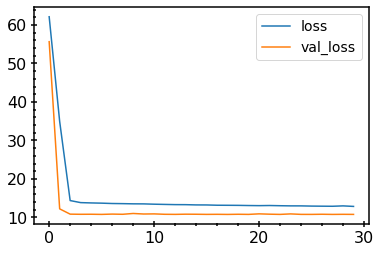

In [27]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(units=32, activation='relu', input_shape=dc_dataset.X.shape[1:]),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'), 
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'), 
    layers.Dropout(0.2),
    layers.Dense(units=1),
])
model.compile(loss='mae', optimizer='adam')

print(model.summary())

history = model.fit(
    train.X, train.y,
    validation_data=(test.X,test.y),
    batch_size=24,
    epochs=30,
)

## perform a plot of loss vs epochs 
import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Use DeepChem Keras Model

In [28]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(units=32, activation='relu', input_shape=dc_dataset.X.shape[1:]),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'), 
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'), 
    layers.Dropout(0.2),
    layers.Dense(units=1),
])

dcmodel = dc.models.KerasModel(model,loss=dc.metrics.mae_score)

In [29]:
dcmodel.fit(dc_dataset)

TypeError: in user code:

    /home/david/anaconda3/envs/deepchem-night/lib/python3.8/site-packages/deepchem/models/keras_model.py:469 apply_gradient_for_batch  *
        batch_loss = loss(outputs, labels, weights)

    TypeError: tf__mae_score() takes 2 positional arguments but 3 were given


# Examples of Classic ML models 

Finally, we will compare others descriptros such as AAcomposition and Composition,transition and distribution of AA (https://www.pnas.org/content/92/19/8700)  

In [30]:
from propy import PyPro

In the following cell, we are creating and pyPro Object based on the protein sequence. Pypro allows us the calculation of amino acid composition vectors


In [31]:
import numpy as np 
aaComplist = []
CTDList =[]
for seq in seq_list:
    Obj = PyPro.GetProDes(seq)
    aaComplist.append(np.array(list(Obj.GetAAComp().values())))
    CTDList.append(np.array(list(Obj.GetCTD().values())))

In [32]:
dc_dataset_aacomp = dc.data.NumpyDataset(X=aaComplist,y=deltaTm)
dc_dataset_ctd = dc.data.NumpyDataset(X=CTDList,y=deltaTm)

In [33]:
from deepchem import splits
splitter = splits.RandomSplitter()
train, test  = splitter.train_test_split(dc_dataset_aacomp,seed=42)
from sklearn.ensemble import RandomForestRegressor
from deepchem.utils.evaluate import Evaluator
import pandas as pd
print("RandomForestRegressor")
seed = 42 # Set a random seed to get stable results
sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
sklearn_model.random_state = seed
model = dc.models.SklearnModel(sklearn_model)
model.fit(train)
metric = dc.metrics.Metric(dc.metrics.mae_score)
train_score = model.evaluate(train, [metric])
test_score = model.evaluate(test, [metric])
print("Train score is : {}".format(train_score))
print("Test score is : {}".format(test_score))


RandomForestRegressor
Train score is : {'mae_score': 1.7592398254884696}
Test score is : {'mae_score': 3.3012025778751513}


In [34]:
print("SupportVectorMachineRegressor")
from sklearn.svm import SVR
svr_sklearn = SVR(kernel="poly",degree=4)
svr_sklearn.random_state = seed 
model = dc.models.SklearnModel(svr_sklearn)
model.fit(train)
metric = dc.metrics.Metric(dc.metrics.mae_score)
train_score = model.evaluate(train, [metric])
test_score = model.evaluate(test, [metric])
print("Train score is : {}".format(train_score))
print("Test score is : {}".format(test_score))

SupportVectorMachineRegressor
Train score is : {'mae_score': 3.2430035735221474}
Test score is : {'mae_score': 4.274203131998766}


# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!